In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
print(tf. __version__)

2.12.0


In [3]:
train_dir = '/content/gdrive/MyDrive/data/Split_0.2_old/train_dir'
test_dir = '/content/gdrive/MyDrive/data/Split_0.2_old/validation_dir'

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    class_mode='categorical',
                                                    target_size=(128,128))

Found 240 images belonging to 2 classes.


In [5]:
train_generator.class_indices

{'Fresh': 0, 'Not_fresh': 1}

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                 class_mode = 'categorical',
                                                 target_size=(128,128))

Found 60 images belonging to 2 classes.


Sample Spinach not fresh image:


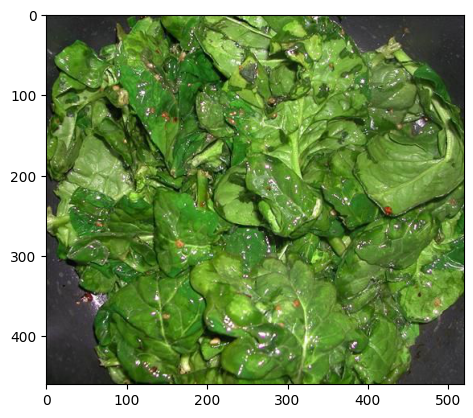

In [7]:
import os
print("Sample Spinach not fresh image:")
train_incidal_dir = os.path.join(train_dir, 'Not_fresh')
plt.imshow(load_img(f"{os.path.join(train_incidal_dir, os.listdir(train_incidal_dir)[10])}"))
plt.show()

In [8]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-03 07:06:51--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  29.3MB/s    in 2.9s    

2023-06-03 07:06:54 (29.3 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [10]:
def make_pre_trained_model(local_weights_file):
    pre_trained_model = InceptionV3(input_shape=(128,128,3),
                                   include_top = False,
                                   weights = None)
    pre_trained_model.load_weights(local_weights_file)
    for layer in pre_trained_model.layers:
        layer.trainable = False
    return pre_trained_model

In [11]:
pre_trained_model = make_pre_trained_model(local_weights_file)
# pre_trained_model.summary()

In [12]:
last_layer_from_tflrn = pre_trained_model.get_layer('mixed7')
last_output = last_layer_from_tflrn.output

In [13]:
def make_final_model(pre_trained_model, last_output):
    x = layers.Flatten()(last_output)
    # x = layers.Dense(128, activation='relu')(x)
    # x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    # x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(2, 'sigmoid')(x)
    model = Model(inputs=pre_trained_model.input, outputs=x)
    model.compile(optimizer=RMSprop(learning_rate=0.0001),
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])
    return model

In [14]:
model = make_final_model(pre_trained_model, last_output)

In [15]:
from tensorflow.keras.callbacks import Callback

#creates a custom callback class
class CustomCallback(Callback):
    """
    This callback will stop the model from training once the model reaches 95% accuracy on the training data
    """
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print('Accuracy above 95% -- Stopping Training')
            self.model.stop_training = True #stops model training

callbacks = CustomCallback()

**TRAINING MODEL**

In [ ]:
history = model.fit(train_generator,
                    validation_data = test_generator,
                    epochs = 50,
                    #batch_size = 360,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/50
8/8 [==============================] - 15s 1s/step - loss: 0.7498 - accuracy: 0.5833 - val_loss: 0.5008 - val_accuracy: 0.8833
Epoch 2/50
8/8 [==============================] - 10s 1s/step - loss: 0.5753 - accuracy: 0.7042 - val_loss: 0.4380 - val_accuracy: 0.8500
Epoch 3/50
8/8 [==============================] - 8s 1s/step - loss: 0.4642 - accuracy: 0.8167 - val_loss: 0.3904 - val_accuracy: 0.8667
Epoch 4/50
8/8 [==============================] - 9s 1s/step - loss: 0.4560 - accuracy: 0.7833 - val_loss: 0.3985 - val_accuracy: 0.8667
Epoch 5/50
8/8 [==============================] - 9s 1s/step - loss: 0.4312 - accuracy: 0.7875 - val_loss: 0.4783 - val_accuracy: 0.7833
Epoch 6/50
8/8 [==============================] - 8s 981ms/step - loss: 0.3912 - accuracy: 0.7958 - val_loss: 0.3493 - val_accuracy: 0.8833
Epoch 7/50
8/8 [==============================] - 9s 1s/step - loss: 0.3510 - accuracy: 0.8667 - val_loss: 0.3370 - val_accuracy: 0.8833
Epoch 8/50
8/8 [====================

Text(0.5, 1.0, 'Training and validation loss')

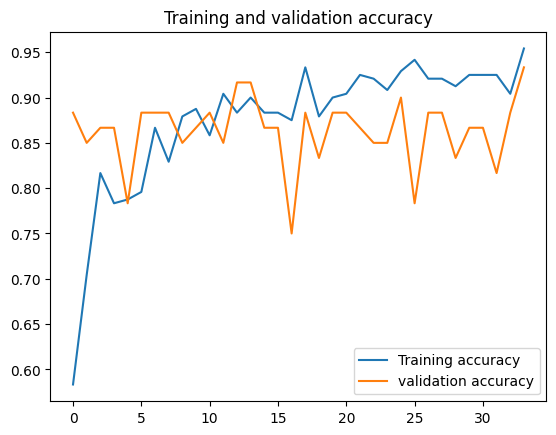

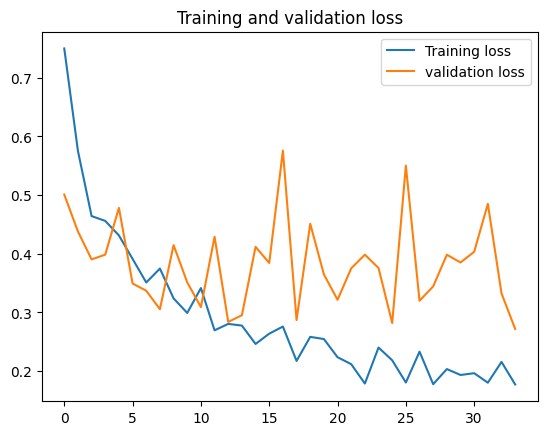

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc,label="Training accuracy")
plt.plot(epochs, val_acc,label="validation accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss,label="Training loss")
plt.plot(epochs, val_loss,label="validation loss")
plt.legend()
plt.title('Training and validation loss')

In [19]:
from keras.models import save_model
#save_model(model, 'Model/acc' +str(acc)+ '_0.2_ideal_detect_freshness_spinach.h5')

In [17]:
from keras.models import load_model

model = load_model('Model/acc0.9333333373069763_0.2_ideal_detect_freshness_spinach.h5')

evaluate = model.evaluate(test_generator)
acc = evaluate[1]

2/2 [==============================] - 2s 727ms/step - loss: 0.2718 - accuracy: 0.9333


In [ ]:
# convert the history.history dict to a pandas DataFrame:  
import pandas as pd   
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history33.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.749811,0.583333,0.500805,0.883333
1,0.575255,0.704167,0.437994,0.850000
2,0.464174,0.816667,0.390391,0.866667
3,0.455967,0.783333,0.398480,0.866667
4,0.431192,0.787500,0.478265,0.783333
5,0.391205,0.795833,0.349331,0.883333
6,0.351023,0.866667,0.336952,0.883333
7,0.374772,0.829167,0.305460,0.883333
8,0.323940,0.879167,0.414731,0.850000
9,0.299128,0.887500,0.351194,0.866667


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

# Save the model.
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

**TESTING MODEL**

In [6]:
import numpy as np
from google.colab import files
from keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('Model/acc0.9333333373069763_0.2_ideal_detect_freshness_spinach.h5')

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(128, 128))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)
  output_class= np.argmax(classes)
  classname = ['Fresh', 'Not fresh']
  print("The predicted class is", classname[output_class])

Saving Fresh_spinach (1).jpg to Fresh_spinach (1).jpg
Saving Fresh_spinach (2).jpg to Fresh_spinach (2).jpg
Saving Fresh_spinach (3).jpg to Fresh_spinach (3).jpg
Saving Fresh_spinach (4).jpeg to Fresh_spinach (4).jpeg
Saving Fresh_spinach (5).jpg to Fresh_spinach (5).jpg
Saving Spinach_not_fresh (1).jpeg to Spinach_not_fresh (1).jpeg
Saving Spinach_not_fresh (2).jpg to Spinach_not_fresh (2).jpg
Saving Spinach_not_fresh (3).jpg to Spinach_not_fresh (3).jpg
Saving Spinach_not_fresh (4).jpg to Spinach_not_fresh (4).jpg
Saving Spinach_not_fresh (5).jpg to Spinach_not_fresh (5).jpg
1/1 [==============================] - 1s 915ms/step
Fresh_spinach (1).jpg
[[0.41708505 0.46501195]]
The predicted class is Not fresh
1/1 [==============================] - 0s 24ms/step
Fresh_spinach (2).jpg
[[0.99873    0.00149822]]
The predicted class is Fresh
1/1 [==============================] - 0s 25ms/step
Fresh_spinach (3).jpg
[[0.9706562  0.01793969]]
The predicted class is Fresh
1/1 [===================